# Domain Adoption

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import math
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

## Functions

#### Define function for Bootstrap resampling to solve the imbalanced probelm

In [3]:
# random sample with replacement from label 1
# label_1_rate: the rate of label 1 in the sampled dataframe, should be between 0 and 1

def rated_sample(df, label_1_rate):

    sampled_label_0 = df[df['label'] == 0]
    label_0_count = len(df[df['label'] == 0])

    #calculate the number of label 1 samples
    sampled_label_1_count = int(label_1_rate * label_0_count)
    
    # random sample with replacement from label 1
    sampled_label_1 = df[df['label'] == 1].sample(n=sampled_label_1_count, replace=True)

    # concatenate the sampled label 0 and sampled label 1
    sampled_df = pd.concat([sampled_label_0, sampled_label_1])
    
    return sampled_df

In [4]:
# random sample without replacement from label 0
# label_0_rate: the rate of label 0 in the sampled dataframe, can be any number

def under_sample(df, label_0_rate):

    sampled_label_1 = df[df['label'] == 1]
    label_1_count = len(df[df['label'] == 1])

    #calculate the number of label 0 samples
    sampled_label_0_count = int(label_0_rate * label_1_count)

    total_label_0 = df[df['label'] == 0]

    # calculate the number needed for each model
    model_count = sampled_label_0_count // 7
    sampled_label_0 = pd.DataFrame()

    # use for loop to sample from each model
    for i in range(7):
        model = total_label_0[total_label_0['model'] == i]
        sampled_model = model.sample(n=model_count, replace=False)
        sampled_label_0 = pd.concat([sampled_label_0, sampled_model])

    # concatenate the sampled label 0 and sampled label 1
    sampled_df = pd.concat([sampled_label_1, sampled_label_0])
    
    return sampled_df

#### Define the bag of word function for a data domain input

In [5]:
def BOW_train_vectorizer(vectorizer_name, data_domain):
    
    # transform train data_domain's text to string 
    corpus = [' '.join(str(word_id) for word_id in document) for document in data_domain['text']]
    
    # learn the token dictionary and return document-term matrix
    data_domain_vec = vectorizer_name.fit_transform(corpus)
    
    # get data in data_domain
    data_domain_BOW = data_domain_vec.toarray()

    print(data_domain_BOW.shape)

    return data_domain_BOW

#### Define the bag of word for valid or prediction data domain input

In [6]:
def BOW_pred_vectorizer(vectorizer, data_domain):
    
    # transform train data_domain's text to string 
    corpus = [' '.join(str(word_id) for word_id in document) for document in data_domain['text']]
    
    # learn the token dictionary and return document-term matrix
    data_domain_vec = vectorizer.transform(corpus)
    
    # get data in data_domain
    data_domain_pred_BOW = data_domain_vec.toarray()

    print(data_domain_pred_BOW.shape)

    return data_domain_pred_BOW

## Load data into system and preprocessing

In [7]:
# load datasets
domain1 = pd.read_json('data/domain1_train.json', lines=True)
domain2 = pd.read_json('data/domain2_train.json', lines=True)
test = pd.read_json('data/test_set.json', lines=True)

In [8]:
over_dm2 = rated_sample(domain2,1)
under_dm2 = under_sample(domain2,1)

In [9]:
# print domain1 and domain2's shape
print(f'domain1 shape: {domain1.shape}')
print(f'domain2 shape: {domain2.shape}')
print(f'over_dm2 shape: {over_dm2.shape}')
print(f'under_dm2 shape: {under_dm2.shape}')

domain1 shape: (19500, 2)
domain2 shape: (14900, 3)
over_dm2 shape: (25500, 3)
under_dm2 shape: (4299, 3)


In [10]:
domain1_mod = domain1.copy()

# assign model 7 to domain1_mod with label 0
domain1_mod.loc[domain1_mod['label'] == 0, 'model'] = 7
# assign model -1 to domain1_mod with label 1
domain1_mod.loc[domain1_mod['label'] == 1, 'model'] = -1

domain1_mod["domain"] = 1

# create a column for domain1_mod to store the text length
domain1_mod['text_length'] = domain1_mod['text'].apply(lambda x: len(x))

over_dm2["domain"] = 2
under_dm2["domain"] = 2

# change the nan model in domain2 to -1
over_dm2['model'] = over_dm2['model'].fillna(-1)
under_dm2['model'] = under_dm2['model'].fillna(-1)

# create a column for dm2 to store the text length
over_dm2['text_length'] = over_dm2['text'].apply(lambda x: len(x))
under_dm2['text_length'] = under_dm2['text'].apply(lambda x: len(x))

print(f'domain1 shape: {domain1_mod.shape}')
print(f'over_dm2 shape: {over_dm2.shape}')
print(f'under_dm2 shape: {under_dm2.shape}')

domain1 shape: (19500, 5)
over_dm2 shape: (25500, 5)
under_dm2 shape: (4299, 5)


In [11]:
# under sample domain1_mod to match the size of under_dm2
under_dm1 = domain1_mod.sample(n=under_dm2.shape[0], replace=False)
under_dm1.shape

(4299, 5)

In [12]:
merge_over_dm = pd.concat([domain1_mod, over_dm2], ignore_index=True)
merge_under_dm = pd.concat([under_dm1, under_dm2], ignore_index=True)

print(f'merge_over_dm shape: {merge_over_dm.shape}')
print(f'merge_under_dm shape: {merge_under_dm.shape}')

merge_over_dm shape: (45000, 5)
merge_under_dm shape: (8598, 5)


## Train test split

In [15]:
train_over_merge, valid_over_merge = train_test_split(merge_over_dm,test_size=0.2,random_state=7)
train_under_merge, valid_under_merge = train_test_split(merge_under_dm,test_size=0.2,random_state=7)

# Domain prediction on Over Sample

In [156]:
train_over_merge_vectorizer = CountVectorizer()
train_over_merge_bow = BOW_train_vectorizer(train_over_merge_vectorizer, train_over_merge)

# add the label, model, and text_length to the BOW matrix as features
train_over_merge_X = np.concatenate((train_over_merge_bow, train_over_merge[['text_length']].to_numpy()), axis=1)
train_over_merge_X.shape

(36000, 4990)


(36000, 4991)

In [157]:
valid_over_merge_bow = BOW_pred_vectorizer(train_over_merge_vectorizer, valid_over_merge)

# add the label, model, and text_length to the BOW matrix as features
valid_over_merge_X = np.concatenate((valid_over_merge_bow, valid_over_merge[['text_length']].to_numpy()), axis=1)
valid_over_merge_X.shape

(9000, 4990)


(9000, 4991)

### Basic LR

In [158]:
lr_over_merge_dm = LogisticRegression(max_iter=150)

In [159]:
lr_over_merge_dm.fit(train_over_merge_X, train_over_merge['domain'])

valid_over_merge_dm_pred = lr_over_merge_dm.predict(valid_over_merge_X)

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [160]:
print("LR merge training score: {}".format(lr_over_merge_dm.score(train_over_merge_X,train_over_merge['domain'])))
print("LR merge valid score: {}".format(lr_over_merge_dm.score(valid_over_merge_X,valid_over_merge['domain'])))

LR merge training score: 0.9965277777777778
LR merge valid score: 0.9876666666666667


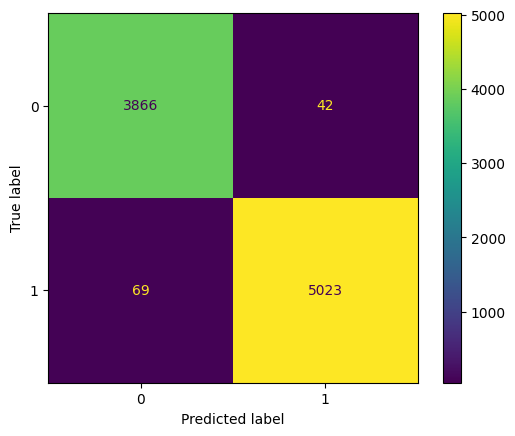

In [161]:
cm_merge = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(valid_over_merge['domain'],valid_over_merge_dm_pred))
cm_merge.plot()

In [162]:
print(classification_report(valid_over_merge['domain'], valid_over_merge_dm_pred))

              precision    recall  f1-score   support

           1       0.98      0.99      0.99      3908
           2       0.99      0.99      0.99      5092

    accuracy                           0.99      9000
   macro avg       0.99      0.99      0.99      9000
weighted avg       0.99      0.99      0.99      9000



In [163]:
print(f1_score(valid_over_merge['domain'], valid_over_merge_dm_pred, average='macro'))

0.9874594142898732


## Grid Search

In [47]:
# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [48]:
clf_lr_over_merge_dm = GridSearchCV(lr_over_merge_dm, param_grid=parameters, scoring='accuracy',cv=5)

In [50]:
clf_lr_over_merge_dm.fit(train_over_merge_X,train_over_merge['domain'])

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

KeyboardInterrupt: 

In [ ]:
valid_over_merge_pred_dm_clf = clf_lr_over_merge_dm.predict(valid_over_merge_X)

In [ ]:
print("LR merge training score: {}".format(clf_lr_over_merge_dm.score(train_over_merge_X,train_over_merge['domain'])))
print("LR merge valid score: {}".format(clf_lr_over_merge_dm.score(valid_over_merge_X,valid_over_merge['domain'])))

LR merge training score: 0.8701666666666666
LR merge valid score: 0.7837777777777778


In [ ]:
print(classification_report(valid_over_merge['domain'], valid_over_merge_pred_dm_clf))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      4530
           1       0.77      0.81      0.79      4470

    accuracy                           0.78      9000
   macro avg       0.78      0.78      0.78      9000
weighted avg       0.78      0.78      0.78      9000



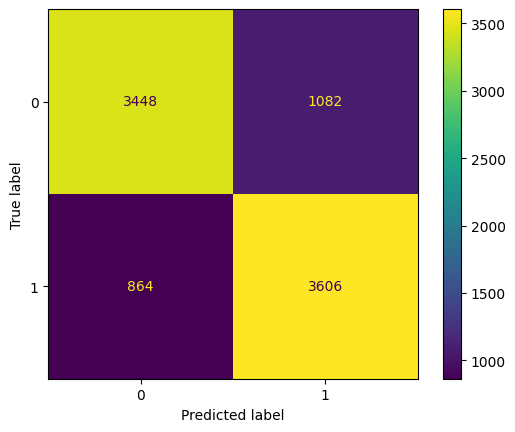

In [ ]:
cm_merge = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(valid_over_merge['domain'],valid_over_merge_pred_dm_clf))
cm_merge.plot()

In [ ]:
print(f1_score(valid_over_merge['domain'], valid_over_merge_pred_dm_clf, average='macro'))

0.7837111180784162


# Domain prediction on Under Sample

In [13]:
from joblib import dump, load

In [14]:
lr_under_merge_dm = load('C:/Users/dell/Desktop/models/lr_under_merge_dm.joblib')
train_under_merge_vectorizer = load('C:/Users/dell/Desktop/models/train_under_merge_vectorizer.joblib')

In [16]:
train_under_merge_vectorizer = CountVectorizer()
train_under_merge_bow = BOW_train_vectorizer(train_under_merge_vectorizer, train_under_merge)

# add the label, model, and text_length to the BOW matrix as features
train_under_merge_X = np.concatenate((train_under_merge_bow, train_under_merge[['text_length']].to_numpy()), axis=1)
train_under_merge_X.shape

(6878, 4984)


(6878, 4985)

In [17]:
valid_under_merge_bow = BOW_pred_vectorizer(train_under_merge_vectorizer, valid_under_merge)

# add the label, model, and text_length to the BOW matrix as features
valid_under_merge_X = np.concatenate((valid_under_merge_bow, valid_under_merge[['text_length']].to_numpy()), axis=1)
valid_under_merge_X.shape

(1720, 4984)


(1720, 4985)

## Basic LR

In [18]:
lr_under_merge_dm = LogisticRegression(max_iter=150)

In [19]:
lr_under_merge_dm.fit(train_under_merge_X, train_under_merge['domain'])

valid_under_merge_dm_pred = lr_under_merge_dm.predict(valid_under_merge_X)

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
print("LR merge training score: {}".format(lr_under_merge_dm.score(train_under_merge_X,train_under_merge['domain'])))
print("LR merge valid score: {}".format(lr_under_merge_dm.score(valid_under_merge_X,valid_under_merge['domain'])))

LR merge training score: 0.9988368711834835
LR merge valid score: 0.9738372093023255


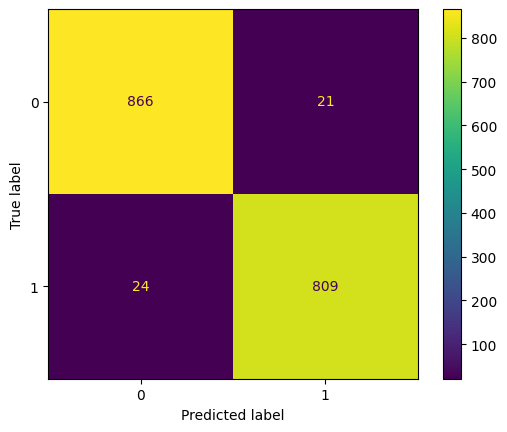

In [21]:
cm_merge = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(valid_under_merge['domain'],valid_under_merge_dm_pred))
cm_merge.plot()

In [22]:
print(classification_report(valid_under_merge['domain'], valid_under_merge_dm_pred))

              precision    recall  f1-score   support

           1       0.97      0.98      0.97       887
           2       0.97      0.97      0.97       833

    accuracy                           0.97      1720
   macro avg       0.97      0.97      0.97      1720
weighted avg       0.97      0.97      0.97      1720



In [23]:
print(f1_score(valid_under_merge['domain'], valid_under_merge_dm_pred, average='macro'))

0.9738084449830144


In [109]:
dump(lr_under_merge_dm, 'C:/Users/dell/Desktop/models/lr_under_merge_dm.joblib')
dump(train_under_merge_vectorizer, 'C:/Users/dell/Desktop/models/train_under_merge_vectorizer.joblib')

['C:/Users/dell/Desktop/models/train_under_merge_vectorizer.joblib']

## Grid Search

In [ ]:
# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [ ]:
clf_lr_under_merge_dm = GridSearchCV(lr_under_merge_dm, param_grid=parameters, scoring='accuracy',cv=5)

In [ ]:
clf_lr_under_merge_dm.fit(train_under_merge_X,train_under_merge['domain'])

In [ ]:
valid_under_merge_pred_dm_clf = clf_lr_under_merge_dm.predict(valid_under_merge_X)

In [ ]:
print("LR merge training score: {}".format(clf_lr_under_merge_dm.score(train_under_merge_X,train_under_merge['domain'])))
print("LR merge valid score: {}".format(clf_lr_under_merge_dm.score(valid_under_merge_X,valid_under_merge['domain'])))

LR merge training score: 0.8701666666666666
LR merge valid score: 0.7837777777777778


In [ ]:
print(classification_report(valid_under_merge['domain'], valid_under_merge_pred_dm_clf))

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      4530
           1       0.77      0.81      0.79      4470

    accuracy                           0.78      9000
   macro avg       0.78      0.78      0.78      9000
weighted avg       0.78      0.78      0.78      9000



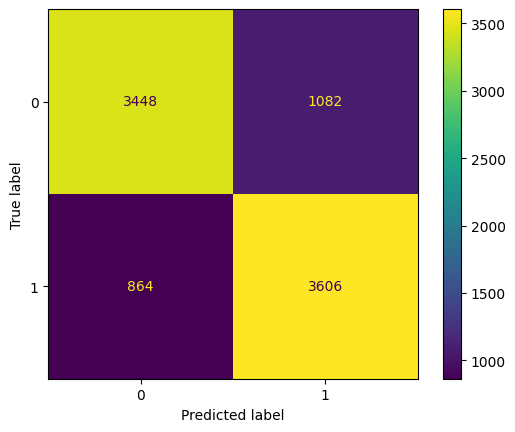

In [ ]:
cm_merge = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(valid_under_merge['domain'],valid_under_merge_pred_dm_clf))
cm_merge.plot()

In [ ]:
print(f1_score(valid_under_merge['domain'], valid_under_merge_pred_dm_clf, average='macro'))

0.7837111180784162


# Label prediction Domain 1

In [26]:
lr_dm1_wc = load('C:/Users/dell/Desktop/models/lr_dm1_wc.joblib')
train_dm1_vectorizer_wc = load('C:/Users/dell/Desktop/models/train_dm1_vectorizer_wc.joblib')

In [24]:
train_dm1, valid_dm1 = train_test_split(domain1,test_size=0.2,random_state=7) 

In [25]:
train_dm1_vectorizer_wc = CountVectorizer(ngram_range=(1,2),max_features=20000)
train_dm1_bow = BOW_train_vectorizer(train_dm1_vectorizer_wc, train_dm1)

(15600, 20000)


In [26]:
valid_dm1_bow = BOW_pred_vectorizer(train_dm1_vectorizer_wc, valid_dm1)

(3900, 20000)


In [27]:
lr_dm1_wc = LogisticRegression(max_iter=150)
lr_dm1_wc.fit(train_dm1_bow,train_dm1['label'])

valid_dm1_wc_pred = lr_dm1_wc.predict(valid_dm1_bow)

In [28]:
print("LR1 capture word combination balanced dm1 training score: {}".format(lr_dm1_wc.score(train_dm1_bow,train_dm1['label'])))
print("LR1 capture word combination balanced dm1 valid score: {}".format(lr_dm1_wc.score(valid_dm1_bow,valid_dm1['label'])))

LR1 capture word combination balanced dm1 training score: 0.9887820512820513
LR1 capture word combination balanced dm1 valid score: 0.9205128205128205


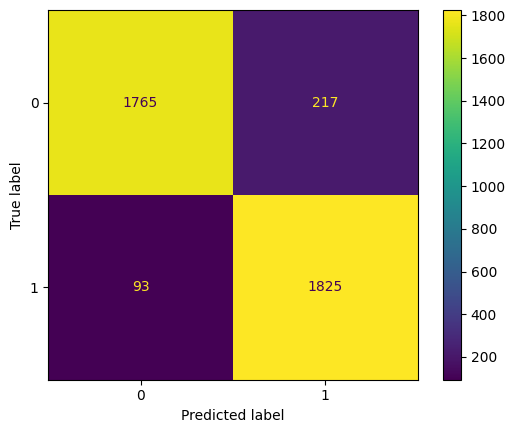

In [29]:
cm_domain1 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(valid_dm1['label'],valid_dm1_wc_pred))
cm_domain1.plot()

In [30]:
print(classification_report(valid_dm1['label'], valid_dm1_wc_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1982
           1       0.89      0.95      0.92      1918

    accuracy                           0.92      3900
   macro avg       0.92      0.92      0.92      3900
weighted avg       0.92      0.92      0.92      3900



In [31]:
print(f1_score(valid_dm1['label'], valid_dm1_wc_pred, average='macro'))

0.9204940025252526


In [110]:
dump(lr_dm1_wc, 'C:/Users/dell/Desktop/models/lr_dm1_wc.joblib')
dump(train_dm1_vectorizer_wc, 'C:/Users/dell/Desktop/models/train_dm1_vectorizer_wc.joblib')

['C:/Users/dell/Desktop/models/train_dm1_vectorizer_wc.joblib']

# Label prediction Domain 2

In [32]:
over_dm2 = rated_sample(domain2,1)
under_dm2 = under_sample(domain2,1)

In [33]:
train_overdm2, valid_overdm2 = train_test_split(over_dm2,test_size=0.2,random_state=7)
train_underdm2, valid_underdm2 = train_test_split(under_dm2,test_size=0.2,random_state=7)

## Over sampling

In [99]:
train_overdm2_vectorizer_wc = CountVectorizer(ngram_range=(1,2),max_features=30000)

## transform train domain2's text to string 
corpus2 = [' '.join(str(word_id) for word_id in document) for document in train_overdm2['text']]
# learn the token dictionary and return document-term matrix
train_overdm2_bow_vec = train_overdm2_vectorizer_wc.fit_transform(corpus2)
# get column names in domain2
# domain2_vec_col = train_overdm2_vectorizer_wc.get_feature_names()
# get data in domain2
train_overdm2_bow = train_overdm2_bow_vec.toarray()

train_overdm2_bow.shape

(20400, 30000)

In [100]:
corpus2_test = [' '.join(str(word_id) for word_id in document) for document in valid_overdm2['text']]
valid_overdm2_bow = train_overdm2_vectorizer_wc.transform(corpus2_test)
valid_overdm2_bow.shape

(5100, 30000)

In [ ]:
# train_overdm2_vectorizer_wc = CountVectorizer(ngram_range=(1,2),max_features=30000)
# train_overdm2_bow = BOW_train_vectorizer(train_overdm2_vectorizer_wc, train_overdm2)

# valid_overdm2_bow = BOW_pred_vectorizer(train_overdm2_vectorizer_wc, valid_overdm2)

In [ ]:
## Logistic regression in domain 2
lr_overdm2_wc = LogisticRegression(max_iter=400)
lr_overdm2_wc.fit(train_overdm2_bow,train_overdm2['label'])

valid_overdm2_wc_pred = lr_overdm2_wc.predict(valid_overdm2_bow)

In [104]:
print("LR capture word combination balanced dm2 training score: {}".format(lr_overdm2_wc.score(train_overdm2_bow,train_overdm2['label'])))
print("LR capture word combination balanced dm2 valid score: {}".format(lr_overdm2_wc.score(valid_overdm2_bow,valid_overdm2['label'])))

LR capture word combination balanced dm2 training score: 0.999656862745098
LR capture word combination balanced dm2 valid score: 0.9319607843137255


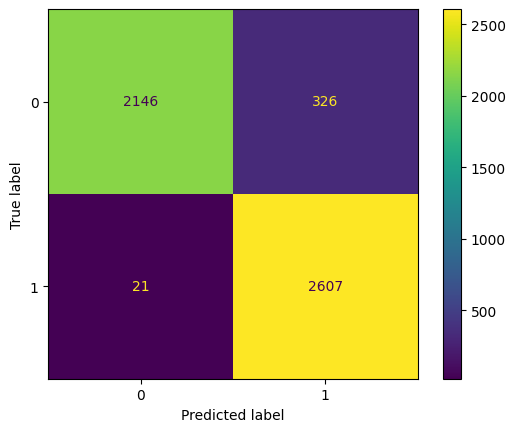

In [105]:
cm_domain2 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(valid_overdm2['label'],valid_overdm2_wc_pred))
cm_domain2.plot()

In [106]:
print(classification_report(valid_overdm2['label'], valid_overdm2_wc_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      2472
           1       0.89      0.99      0.94      2628

    accuracy                           0.93      5100
   macro avg       0.94      0.93      0.93      5100
weighted avg       0.94      0.93      0.93      5100



In [107]:
print(f1_score(valid_overdm2['label'], valid_overdm2_wc_pred, average='macro'))

0.9314002736468939


## Under Sampling

In [ ]:
lr_underdm2_wc = load('C:/Users/dell/Desktop/models/lr_underdm2_wc.joblib')
train_underdm2_vectorizer_wc = load('C:/Users/dell/Desktop/models/train_underdm2_vectorizer_wc.joblib')

In [66]:
train_underdm2_vectorizer_wc = CountVectorizer(ngram_range=(1,2),max_features=20000)

## transform train domain2's text to string 
corpus2 = [' '.join(str(word_id) for word_id in document) for document in train_underdm2['text']]
# learn the token dictionary and return document-term matrix
train_underdm2_bow_vec = train_underdm2_vectorizer_wc.fit_transform(corpus2)
# get column names in domain2
# domain2_vec_col = train_underdm2_vectorizer_wc.get_feature_names()
# get data in domain2
train_underdm2_bow = train_underdm2_bow_vec.toarray()

train_underdm2_bow.shape

(3439, 20000)

In [67]:
corpus2_test = [' '.join(str(word_id) for word_id in document) for document in valid_underdm2['text']]
valid_underdm2_bow = train_underdm2_vectorizer_wc.transform(corpus2_test)
valid_underdm2_bow.shape

(860, 20000)

In [ ]:
# train_underdm2_vectorizer_wc = CountVectorizer(ngram_range=(1,2),max_features=30000)
# train_underdm2_bow = BOW_train_vectorizer(train_underdm2_vectorizer_wc, train_underdm2)

# valid_underdm2_bow = BOW_pred_vectorizer(train_underdm2_vectorizer_wc, valid_underdm2)

In [61]:
## Logistic regression in domain 2
lr_underdm2_wc = LogisticRegression(max_iter=50)
lr_underdm2_wc.fit(train_underdm2_bow,train_underdm2['label'])

valid_underdm2_wc_pred = lr_underdm2_wc.predict(valid_underdm2_bow)

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
print("LR capture word combination balanced dm2 training score: {}".format(lr_underdm2_wc.score(train_underdm2_bow,train_underdm2['label'])))
print("LR capture word combination balanced dm2 valid score: {}".format(lr_underdm2_wc.score(valid_underdm2_bow,valid_underdm2['label'])))

LR capture word combination balanced dm2 training score: 0.9982553067752253
LR capture word combination balanced dm2 valid score: 0.608139534883721


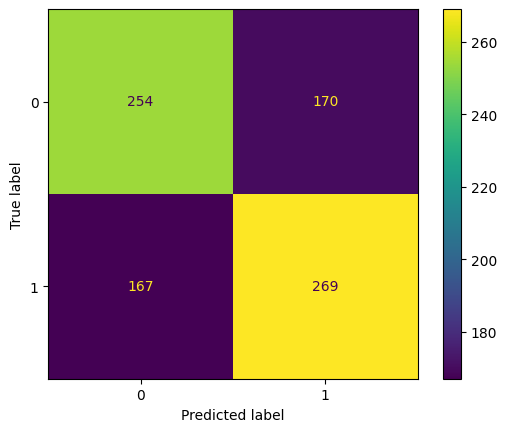

In [63]:
cm_domain2 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(valid_underdm2['label'],valid_underdm2_wc_pred))
cm_domain2.plot()

In [64]:
print(classification_report(valid_underdm2['label'], valid_underdm2_wc_pred))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60       424
           1       0.61      0.62      0.61       436

    accuracy                           0.61       860
   macro avg       0.61      0.61      0.61       860
weighted avg       0.61      0.61      0.61       860



In [65]:
print(f1_score(valid_underdm2['label'], valid_underdm2_wc_pred, average='macro'))

0.6080202874049028


In [111]:
dump(lr_underdm2_wc, 'C:/Users/dell/Desktop/models/lr_underdm2_wc.joblib')
dump(train_underdm2_vectorizer_wc, 'C:/Users/dell/Desktop/models/train_underdm2_vectorizer_wc.joblib')

['C:/Users/dell/Desktop/models/train_underdm2_vectorizer_wc.joblib']

# Validation for 2 step model

In [80]:
valid_under_merge

,text,label,model,domain,text_length
52,"[1506, 711, 2, 48, 6, 213, 8, 224, 17, 542, 18...",0,7.0,1,37
2034,"[0, 3, 39, 1011, 2869, 6, 0, 22, 0, 33, 0, 1]",1,-1.0,1,12
3663,"[2, 92, 255, 985, 33, 2, 500, 113, 157, 17, 22...",0,7.0,1,38
1994,"[2, 0, 3, 14, 23, 3, 17, 2908, 4, 2, 0, 118, 6...",1,-1.0,1,19
4610,"[40, 2467, 98, 49, 77, 28, 31, 0, 806, 17, 5, ...",1,-1.0,2,211
...,...,...,...,...,...
2488,"[153, 4, 4336, 3, 1342, 46, 1, 247, 3, 24, 0, ...",0,7.0,1,28
3479,"[11, 32, 55, 3805, 4, 2, 1164, 9, 30, 112, 3, ...",0,7.0,1,29
6491,"[2, 84, 634, 1566, 72, 5, 2006, 146, 1954, 608...",0,0.0,2,200
59,"[16, 164, 6, 20, 151, 0, 4, 2, 577, 12, 807, 4...",1,-1.0,1,51


In [81]:
# 先用lr_under_merge_dm模型预测domain
valid_under_dm_pred_bow = BOW_pred_vectorizer(train_under_merge_vectorizer, valid_under_merge)

# add the text_length to the BOW matrix as features
valid_under_dm_pred_X = np.concatenate((valid_under_dm_pred_bow, valid_under_merge[['text_length']].to_numpy()), axis=1)
valid_under_dm_pred_X.shape

(1720, 4984)


(1720, 4985)

In [82]:
# predict domain
valid_under_dm_pred = lr_under_merge_dm.predict(valid_under_dm_pred_X)

In [83]:
Counter(valid_under_dm_pred)

Counter({1: 890, 2: 830})

In [84]:
# add the predicted domain to the test dataframe
valid_under_merge['domain_pred'] = valid_under_dm_pred
valid_under_merge

,text,label,model,domain,text_length,domain_pred
52,"[1506, 711, 2, 48, 6, 213, 8, 224, 17, 542, 18...",0,7.0,1,37,1
2034,"[0, 3, 39, 1011, 2869, 6, 0, 22, 0, 33, 0, 1]",1,-1.0,1,12,1
3663,"[2, 92, 255, 985, 33, 2, 500, 113, 157, 17, 22...",0,7.0,1,38,1
1994,"[2, 0, 3, 14, 23, 3, 17, 2908, 4, 2, 0, 118, 6...",1,-1.0,1,19,1
4610,"[40, 2467, 98, 49, 77, 28, 31, 0, 806, 17, 5, ...",1,-1.0,2,211,2
...,...,...,...,...,...,...
2488,"[153, 4, 4336, 3, 1342, 46, 1, 247, 3, 24, 0, ...",0,7.0,1,28,1
3479,"[11, 32, 55, 3805, 4, 2, 1164, 9, 30, 112, 3, ...",0,7.0,1,29,1
6491,"[2, 84, 634, 1566, 72, 5, 2006, 146, 1954, 608...",0,0.0,2,200,2
59,"[16, 164, 6, 20, 151, 0, 4, 2, 577, 12, 807, 4...",1,-1.0,1,51,1


In [90]:
valid_dm1_pred_bow = BOW_pred_vectorizer(train_dm1_vectorizer_wc, valid_under_merge.iloc[[1]])
valid_dm1_pred_bow

(1, 20000)


array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [91]:
valid_dm1_pred = lr_dm1_wc.predict(valid_dm1_pred_bow)
valid_dm1_pred

array([1], dtype=int64)

In [101]:
# remove the index of valid_under_merge
valid_under_merge = valid_under_merge.reset_index(drop=True)

In [103]:
# create a column to store the predicted label
valid_under_merge['label_pred'] = 0

# use for loop to predict the label in each domain
# if the domain_pred is 1, use lr_dm1_wc to predict the label
# if the domain_pred is 2, use lr_underdm2_wc to predict the label

for i in range(0, 1719):
    
    # if the domain is 1, use lr_dm1_wc to predict the label
    if valid_under_merge['domain_pred'][i] == 1:
        valid_dm1_pred_bow = BOW_pred_vectorizer(train_dm1_vectorizer_wc, valid_under_merge.iloc[[i]])
        valid_dm1_pred = lr_dm1_wc.predict(valid_dm1_pred_bow)
        valid_under_merge['label_pred'][i] = valid_dm1_pred
    
    # if the domain is 2, use lr_underdm2_wc to predict the label
    elif valid_under_merge['domain_pred'][i] == 2:
        valid_underdm2_pred_bow = BOW_pred_vectorizer(train_underdm2_vectorizer_wc, valid_under_merge.iloc[[i]])
        valid_underdm2_pred = lr_underdm2_wc.predict(valid_underdm2_pred_bow)
        valid_under_merge['label_pred'][i] = valid_underdm2_pred

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_under_merge['label_pred'][i] = valid_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\1640920342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [104]:
valid_under_merge

,text,label,model,domain,text_length,domain_pred,label_pred
0,"[1506, 711, 2, 48, 6, 213, 8, 224, 17, 542, 18...",0,7.0,1,37,1,0
1,"[0, 3, 39, 1011, 2869, 6, 0, 22, 0, 33, 0, 1]",1,-1.0,1,12,1,1
2,"[2, 92, 255, 985, 33, 2, 500, 113, 157, 17, 22...",0,7.0,1,38,1,0
3,"[2, 0, 3, 14, 23, 3, 17, 2908, 4, 2, 0, 118, 6...",1,-1.0,1,19,1,1
4,"[40, 2467, 98, 49, 77, 28, 31, 0, 806, 17, 5, ...",1,-1.0,2,211,2,1
...,...,...,...,...,...,...,...
1715,"[153, 4, 4336, 3, 1342, 46, 1, 247, 3, 24, 0, ...",0,7.0,1,28,1,0
1716,"[11, 32, 55, 3805, 4, 2, 1164, 9, 30, 112, 3, ...",0,7.0,1,29,1,0
1717,"[2, 84, 634, 1566, 72, 5, 2006, 146, 1954, 608...",0,0.0,2,200,2,1
1718,"[16, 164, 6, 20, 151, 0, 4, 2, 577, 12, 807, 4...",1,-1.0,1,51,1,1


In [105]:
# calculate the accuracy of the predicted label
accuracy_score(valid_under_merge['label'], valid_under_merge['label_pred'])

0.8860465116279069

In [106]:
# calculate the f1 score of the predicted label
f1_score(valid_under_merge['label'], valid_under_merge['label_pred'], average='macro')

0.8855954520527118

# Predict text by it's domain in the test set

In [18]:
# add a column to store the text length
test['text_length'] = test['text'].apply(lambda x: len(x))

In [69]:
test

,id,text,text_length
0,0,"[59, 2, 3434, 1013, 823, 2, 887, 6, 2375, 0, 3...",204
1,1,"[2, 785, 6, 5, 0, 317, 17, 5, 2970, 3654, 858,...",150
2,2,"[3306, 4, 2, 2288, 6, 963, 94]",7
3,3,"[0, 2, 1021, 38, 126, 1, 907, 1, 761, 1, 3357,...",27
4,4,"[30, 488, 197, 18, 4, 31, 420, 18, 2, 3577, 6,...",77
...,...,...,...
995,995,"[45, 88, 79, 503, 501, 134, 35, 147, 301, 0, 1...",128
996,996,"[0, 0, 8, 15, 0, 810, 3, 2337, 9, 4653, 3, 41,...",29
997,997,"[2, 495, 752, 17, 128, 9, 2, 3361, 6, 458, 131...",18
998,998,"[2, 4433, 299, 307, 12, 100, 0, 446, 32, 44, 0...",42


## Over Sampling

In [201]:
test_over = test.copy()

In [ ]:
# 预测text的label分成两步，第一步预测domain，第二步在domain内预测label

In [202]:
# 先用lr_over_merge_dm模型预测domain
test_over_dm_pred_bow = BOW_pred_vectorizer(train_over_merge_vectorizer, test_over)

# add the text_length to the BOW matrix as features
test_over_dm_pred_X = np.concatenate((test_over_dm_pred_bow, test_over[['text_length']].to_numpy()), axis=1)
test_over_dm_pred_X.shape

(1000, 4990)


(1000, 4991)

In [203]:
# predict domain
test_over_dm_pred = lr_over_merge_dm.predict(test_over_dm_pred_X)

In [204]:
Counter(test_over_dm_pred)

Counter({2: 503, 1: 497})

In [205]:
# add the predicted domain to the test dataframe
test_over['domain_pred'] = test_over_dm_pred

In [206]:
test_over

,id,text,text_length,domain_pred
0,0,"[59, 2, 3434, 1013, 823, 2, 887, 6, 2375, 0, 3...",204,2
1,1,"[2, 785, 6, 5, 0, 317, 17, 5, 2970, 3654, 858,...",150,2
2,2,"[3306, 4, 2, 2288, 6, 963, 94]",7,1
3,3,"[0, 2, 1021, 38, 126, 1, 907, 1, 761, 1, 3357,...",27,1
4,4,"[30, 488, 197, 18, 4, 31, 420, 18, 2, 3577, 6,...",77,1
...,...,...,...,...
995,995,"[45, 88, 79, 503, 501, 134, 35, 147, 301, 0, 1...",128,2
996,996,"[0, 0, 8, 15, 0, 810, 3, 2337, 9, 4653, 3, 41,...",29,1
997,997,"[2, 495, 752, 17, 128, 9, 2, 3361, 6, 458, 131...",18,1
998,998,"[2, 4433, 299, 307, 12, 100, 0, 446, 32, 44, 0...",42,1


In [207]:
# create a column to store the predicted label
test_over['label_pred'] = 0

# use for loop to predict the label in each domain
# if the domain_pred is 1, use lr_dm1_wc to predict the label
# if the domain_pred is 2, use lr_overdm2_wc to predict the label

for i in range(0, 999):
    
    # if the domain is 1, use lr_dm1_wc to predict the label
    if test_over['domain_pred'][i] == 1:
        test_dm1_pred_bow = BOW_pred_vectorizer(train_dm1_vectorizer_wc, test_over.iloc[[i]])
        test_dm1_pred = lr_dm1_wc.predict(test_dm1_pred_bow)
        test_over['label_pred'][i] = test_dm1_pred
    
    # if the domain is 2, use lr_overdm2_wc to predict the label
    elif test_over['domain_pred'][i] == 2:
        test_overdm2_pred_bow = BOW_pred_vectorizer(train_overdm2_vectorizer_wc, test_over.iloc[[i]])
        test_overdm2_pred = lr_overdm2_wc.predict(test_overdm2_pred_bow)
        test_over['label_pred'][i] = test_overdm2_pred


(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)

C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_overdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_overdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_o

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)

C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_overdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over[

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)

C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['lab

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)

C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_overdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_overdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_o

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)

C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_overdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over[

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)

C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_overdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_overdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_o

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)

C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_overdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over[

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)

C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_overdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\3433521857.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_over[

In [209]:
test_over

,id,text,text_length,domain_pred,label_pred
0,0,"[59, 2, 3434, 1013, 823, 2, 887, 6, 2375, 0, 3...",204,2,1
1,1,"[2, 785, 6, 5, 0, 317, 17, 5, 2970, 3654, 858,...",150,2,0
2,2,"[3306, 4, 2, 2288, 6, 963, 94]",7,1,1
3,3,"[0, 2, 1021, 38, 126, 1, 907, 1, 761, 1, 3357,...",27,1,0
4,4,"[30, 488, 197, 18, 4, 31, 420, 18, 2, 3577, 6,...",77,1,0
...,...,...,...,...,...
995,995,"[45, 88, 79, 503, 501, 134, 35, 147, 301, 0, 1...",128,2,0
996,996,"[0, 0, 8, 15, 0, 810, 3, 2337, 9, 4653, 3, 41,...",29,1,1
997,997,"[2, 495, 752, 17, 128, 9, 2, 3361, 6, 458, 131...",18,1,0
998,998,"[2, 4433, 299, 307, 12, 100, 0, 446, 32, 44, 0...",42,1,1


In [210]:
Counter(test_over['label_pred'])

Counter({1: 380, 0: 620})

In [197]:
df = pd.DataFrame({'id': test_over['id'], 'class': test_over['label_pred']})
df.to_csv('data/BOW_LR_over_sample_Domain_Adoption_pred.csv', index=False)

## Under Sampling

In [70]:
test_under = test.copy()

In [71]:
# 先用lr_under_merge_dm模型预测domain
test_under_dm_pred_bow = BOW_pred_vectorizer(train_under_merge_vectorizer, test_under)

# add the text_length to the BOW matrix as features
test_under_dm_pred_X = np.concatenate((test_under_dm_pred_bow, test_under[['text_length']].to_numpy()), axis=1)
test_under_dm_pred_X.shape

(1000, 4984)


(1000, 4985)

In [72]:
# predict domain
test_under_dm_pred = lr_under_merge_dm.predict(test_under_dm_pred_X)

In [73]:
Counter(test_under_dm_pred)

Counter({2: 503, 1: 497})

In [74]:
# add the predicted domain to the test dataframe
test_under['domain_pred'] = test_under_dm_pred

In [75]:
test_under

,id,text,text_length,domain_pred
0,0,"[59, 2, 3434, 1013, 823, 2, 887, 6, 2375, 0, 3...",204,2
1,1,"[2, 785, 6, 5, 0, 317, 17, 5, 2970, 3654, 858,...",150,2
2,2,"[3306, 4, 2, 2288, 6, 963, 94]",7,1
3,3,"[0, 2, 1021, 38, 126, 1, 907, 1, 761, 1, 3357,...",27,1
4,4,"[30, 488, 197, 18, 4, 31, 420, 18, 2, 3577, 6,...",77,1
...,...,...,...,...
995,995,"[45, 88, 79, 503, 501, 134, 35, 147, 301, 0, 1...",128,2
996,996,"[0, 0, 8, 15, 0, 810, 3, 2337, 9, 4653, 3, 41,...",29,1
997,997,"[2, 495, 752, 17, 128, 9, 2, 3361, 6, 458, 131...",18,1
998,998,"[2, 4433, 299, 307, 12, 100, 0, 446, 32, 44, 0...",42,1


In [76]:
# create a column to store the predicted label
test_under['label_pred'] = 0

# use for loop to predict the label in each domain
# if the domain_pred is 1, use lr_dm1_wc to predict the label
# if the domain_pred is 2, use lr_underdm2_wc to predict the label

for i in range(0, 999):
    
    # if the domain is 1, use lr_dm1_wc to predict the label
    if test_under['domain_pred'][i] == 1:
        test_dm1_pred_bow = BOW_pred_vectorizer(train_dm1_vectorizer_wc, test_under.iloc[[i]])
        test_dm1_pred = lr_dm1_wc.predict(test_dm1_pred_bow)
        test_under['label_pred'][i] = test_dm1_pred
    
    # if the domain is 2, use lr_underdm2_wc to predict the label
    elif test_under['domain_pred'][i] == 2:
        test_underdm2_pred_bow = BOW_pred_vectorizer(train_underdm2_vectorizer_wc, test_under.iloc[[i]])
        test_underdm2_pred = lr_underdm2_wc.predict(test_underdm2_pred_bow)
        test_under['label_pred'][i] = test_underdm2_pred


(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['lab

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)

C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)


C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_3880\2366130646.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

In [77]:
test_under

,id,text,text_length,domain_pred,label_pred
0,0,"[59, 2, 3434, 1013, 823, 2, 887, 6, 2375, 0, 3...",204,2,1
1,1,"[2, 785, 6, 5, 0, 317, 17, 5, 2970, 3654, 858,...",150,2,0
2,2,"[3306, 4, 2, 2288, 6, 963, 94]",7,1,1
3,3,"[0, 2, 1021, 38, 126, 1, 907, 1, 761, 1, 3357,...",27,1,0
4,4,"[30, 488, 197, 18, 4, 31, 420, 18, 2, 3577, 6,...",77,1,0
...,...,...,...,...,...
995,995,"[45, 88, 79, 503, 501, 134, 35, 147, 301, 0, 1...",128,2,0
996,996,"[0, 0, 8, 15, 0, 810, 3, 2337, 9, 4653, 3, 41,...",29,1,1
997,997,"[2, 495, 752, 17, 128, 9, 2, 3361, 6, 458, 131...",18,1,0
998,998,"[2, 4433, 299, 307, 12, 100, 0, 446, 32, 44, 0...",42,1,1


In [78]:
Counter(test_under['label_pred'])

Counter({1: 532, 0: 468})

In [79]:
df = pd.DataFrame({'id': test_under['id'], 'class': test_under['label_pred']})
df.to_csv('data/LR_under_sample_Domain_Adoption_pred_v2.csv', index=False)

In [112]:
# dump test_under to csv
test_under.to_csv('C:/Users/dell/Desktop/models/test_under.csv', index=False)

## Random forest in Domain 2

In [229]:
## Randon Forest in domain 2
from sklearn.ensemble import RandomForestClassifier
lr_underdm2_rf = RandomForestClassifier(n_estimators=100, max_depth=80)
lr_underdm2_rf.fit(train_underdm2_bow,train_underdm2['label'])

valid_underdm2_rf_pred = lr_underdm2_rf.predict(valid_underdm2_bow)

In [230]:
print(f1_score(valid_underdm2['label'], valid_underdm2_rf_pred, average='macro'))

0.6522686918763075


In [223]:
test_under_rf = test.copy()

In [224]:
# 先用lr_under_merge_dm模型预测domain
test_under_dm_pred_bow = BOW_pred_vectorizer(train_under_merge_vectorizer, test_under_rf)

# add the text_length to the BOW matrix as features
test_under_dm_pred_X = np.concatenate((test_under_dm_pred_bow, test_under_rf[['text_length']].to_numpy()), axis=1)
test_under_dm_pred_X.shape

(1000, 4985)


(1000, 4986)

In [225]:
# predict domain
test_under_dm_pred = lr_under_merge_dm.predict(test_under_dm_pred_X)

In [226]:
Counter(test_under_dm_pred)

Counter({2: 501, 1: 499})

In [227]:
# add the predicted domain to the test dataframe
test_under_rf['domain_pred'] = test_under_dm_pred

In [228]:
test_under_rf

,id,text,text_length,domain_pred
0,0,"[59, 2, 3434, 1013, 823, 2, 887, 6, 2375, 0, 3...",204,2
1,1,"[2, 785, 6, 5, 0, 317, 17, 5, 2970, 3654, 858,...",150,2
2,2,"[3306, 4, 2, 2288, 6, 963, 94]",7,1
3,3,"[0, 2, 1021, 38, 126, 1, 907, 1, 761, 1, 3357,...",27,1
4,4,"[30, 488, 197, 18, 4, 31, 420, 18, 2, 3577, 6,...",77,1
...,...,...,...,...
995,995,"[45, 88, 79, 503, 501, 134, 35, 147, 301, 0, 1...",128,2
996,996,"[0, 0, 8, 15, 0, 810, 3, 2337, 9, 4653, 3, 41,...",29,1
997,997,"[2, 495, 752, 17, 128, 9, 2, 3361, 6, 458, 131...",18,1
998,998,"[2, 4433, 299, 307, 12, 100, 0, 446, 32, 44, 0...",42,1


In [231]:
# create a column to store the predicted label
test_under_rf['label_pred'] = 0

# use for loop to predict the label in each domain
# if the domain_pred is 1, use lr_dm1_wc to predict the label
# if the domain_pred is 2, use lr_underdm2_wc to predict the label

for i in range(0, 999):
    
    # if the domain is 1, use lr_dm1_wc to predict the label
    if test_under_rf['domain_pred'][i] == 1:
        test_dm1_pred_bow = BOW_pred_vectorizer(train_dm1_vectorizer_wc, test_under_rf.iloc[[i]])
        test_dm1_pred = lr_dm1_wc.predict(test_dm1_pred_bow)
        test_under_rf['label_pred'][i] = test_dm1_pred
    
    # if the domain is 2, use lr_underdm2_wc to predict the label
    elif test_under_rf['domain_pred'][i] == 2:
        test_underdm2_pred_bow = BOW_pred_vectorizer(train_underdm2_vectorizer_wc, test_under_rf.iloc[[i]])
        test_underdm2_pred = lr_underdm2_rf.predict(test_underdm2_pred_bow)
        test_under_rf['label_pred'][i] = test_underdm2_pred


(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_unde

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_unde

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_unde

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test

(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)
(1, 30000)


C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under_rf['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_17168\756634369.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [232]:
test_under_rf

,id,text,text_length,domain_pred,label_pred
0,0,"[59, 2, 3434, 1013, 823, 2, 887, 6, 2375, 0, 3...",204,2,1
1,1,"[2, 785, 6, 5, 0, 317, 17, 5, 2970, 3654, 858,...",150,2,0
2,2,"[3306, 4, 2, 2288, 6, 963, 94]",7,1,1
3,3,"[0, 2, 1021, 38, 126, 1, 907, 1, 761, 1, 3357,...",27,1,0
4,4,"[30, 488, 197, 18, 4, 31, 420, 18, 2, 3577, 6,...",77,1,0
...,...,...,...,...,...
995,995,"[45, 88, 79, 503, 501, 134, 35, 147, 301, 0, 1...",128,2,1
996,996,"[0, 0, 8, 15, 0, 810, 3, 2337, 9, 4653, 3, 41,...",29,1,1
997,997,"[2, 495, 752, 17, 128, 9, 2, 3361, 6, 458, 131...",18,1,0
998,998,"[2, 4433, 299, 307, 12, 100, 0, 446, 32, 44, 0...",42,1,1


In [233]:
Counter(test_under_rf['label_pred'])

Counter({1: 547, 0: 453})

In [ ]:
df = pd.DataFrame({'id': test_under_rf['id'], 'class': test_under_rf['label_pred']})
df.to_csv('data/BOW_RF_under_sample_Domain_Adoption_pred.csv', index=False)

## SVM in domain 2

In [ ]:
from joblib import dump, load

In [15]:
svm_underdm2 = load('C:/Users/dell/Desktop/svm_models/svm_underdm2.joblib')
svm_underdm2_vectorizer = load('C:/Users/dell/Desktop/svm_models/svm_underdm2_vectorizer.joblib')

In [19]:
test_under = test.copy()

In [20]:
# 先用lr_under_merge_dm模型预测domain
test_under_dm_pred_bow = BOW_pred_vectorizer(train_under_merge_vectorizer, test_under)

# add the text_length to the BOW matrix as features
test_under_dm_pred_X = np.concatenate((test_under_dm_pred_bow, test_under[['text_length']].to_numpy()), axis=1)
test_under_dm_pred_X.shape

(1000, 4984)


(1000, 4985)

In [21]:
# predict domain
test_under_dm_pred = lr_under_merge_dm.predict(test_under_dm_pred_X)

In [22]:
Counter(test_under_dm_pred)

Counter({2: 503, 1: 497})

In [23]:
# add the predicted domain to the test dataframe
test_under['domain_pred'] = test_under_dm_pred

In [24]:
test_under

,id,text,text_length,domain_pred
0,0,"[59, 2, 3434, 1013, 823, 2, 887, 6, 2375, 0, 3...",204,2
1,1,"[2, 785, 6, 5, 0, 317, 17, 5, 2970, 3654, 858,...",150,2
2,2,"[3306, 4, 2, 2288, 6, 963, 94]",7,1
3,3,"[0, 2, 1021, 38, 126, 1, 907, 1, 761, 1, 3357,...",27,1
4,4,"[30, 488, 197, 18, 4, 31, 420, 18, 2, 3577, 6,...",77,1
...,...,...,...,...
995,995,"[45, 88, 79, 503, 501, 134, 35, 147, 301, 0, 1...",128,2
996,996,"[0, 0, 8, 15, 0, 810, 3, 2337, 9, 4653, 3, 41,...",29,1
997,997,"[2, 495, 752, 17, 128, 9, 2, 3361, 6, 458, 131...",18,1
998,998,"[2, 4433, 299, 307, 12, 100, 0, 446, 32, 44, 0...",42,1


In [27]:
# create a column to store the predicted label
test_under['label_pred'] = 0

# use for loop to predict the label in each domain
# if the domain_pred is 1, use lr_dm1_wc to predict the label
# if the domain_pred is 2, use svm_underdm2 to predict the label

for i in range(0, 999):
    
    # if the domain is 1, use lr_dm1_wc to predict the label
    if test_under['domain_pred'][i] == 1:
        test_dm1_pred_bow = BOW_pred_vectorizer(train_dm1_vectorizer_wc, test_under.iloc[[i]])
        test_dm1_pred = lr_dm1_wc.predict(test_dm1_pred_bow)
        test_under['label_pred'][i] = test_dm1_pred
    
    # if the domain is 2, use lr_underdm2_wc to predict the label
    elif test_under['domain_pred'][i] == 2:
        test_underdm2_pred_bow = BOW_pred_vectorizer(svm_underdm2_vectorizer, test_under.iloc[[i]])
        test_underdm2_pred = svm_underdm2.predict(test_underdm2_pred_bow)
        test_under['label_pred'][i] = test_underdm2_pred


(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 4904)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_dm1_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under

(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 4904)
(1, 20000)
(1, 20000)
(1, 20000)


C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['label_pred'][i] = test_underdm2_pred
C:\Users\dell\AppData\Local\Temp\ipykernel_13548\303323239.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_

In [28]:
test_under

,id,text,text_length,domain_pred,label_pred
0,0,"[59, 2, 3434, 1013, 823, 2, 887, 6, 2375, 0, 3...",204,2,1
1,1,"[2, 785, 6, 5, 0, 317, 17, 5, 2970, 3654, 858,...",150,2,0
2,2,"[3306, 4, 2, 2288, 6, 963, 94]",7,1,1
3,3,"[0, 2, 1021, 38, 126, 1, 907, 1, 761, 1, 3357,...",27,1,0
4,4,"[30, 488, 197, 18, 4, 31, 420, 18, 2, 3577, 6,...",77,1,0
...,...,...,...,...,...
995,995,"[45, 88, 79, 503, 501, 134, 35, 147, 301, 0, 1...",128,2,0
996,996,"[0, 0, 8, 15, 0, 810, 3, 2337, 9, 4653, 3, 41,...",29,1,1
997,997,"[2, 495, 752, 17, 128, 9, 2, 3361, 6, 458, 131...",18,1,0
998,998,"[2, 4433, 299, 307, 12, 100, 0, 446, 32, 44, 0...",42,1,1


In [29]:
Counter(test_under['label_pred'])

Counter({1: 508, 0: 492})

In [30]:
df = pd.DataFrame({'id': test_under['id'], 'class': test_under['label_pred']})
df.to_csv('data/LR_SVM_under_sample_Domain_Adoption_pred.csv', index=False)

In [31]:
# dump test_under to csv
test_under.to_csv('C:/Users/dell/Desktop/models/test_under_svm.csv', index=False)